In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange
import itertools
from torchvision.utils import make_grid

In [0]:
num_epochs = 100
batch_size = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Data Loading**

In [0]:
trfs = transforms.Compose([
    transforms.ToTensor()
])

imgs_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=trfs)

imgs_dataloader = DataLoader(imgs_dataset, batch_size=batch_size, shuffle=True)

**Samples**

In [0]:
def im_show(tensor):
    image = tensor.squeeze().numpy()
    plt.imshow(image)

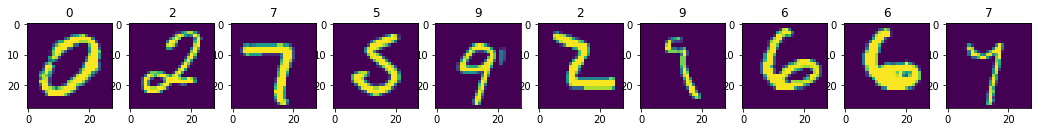

In [0]:
imgs, labels = next(iter(imgs_dataloader))
plt.figure(figsize=(18, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.title(labels[i].item())
    im_show(imgs[i])

**Model Definition**

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(True),
            nn.Linear(1000, 1000),
            nn.ReLU(True),
            nn.Linear(1000, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 1000),
            nn.ReLU(True),
            nn.Linear(1000, 1000),
            nn.ReLU(True),
            nn.Linear(1000, 784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y = self.encoder(x)
        y = self.decoder(y)
        return y

In [0]:
ae = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.001)

if torch.cuda.device_count() > 1:
    ae = nn.DataParallel(ae)
    
ae = ae.to(device)
print(ae)

DataParallel(
  (module): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=1000, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=1000, out_features=1000, bias=True)
      (3): ReLU(inplace)
      (4): Linear(in_features=1000, out_features=2, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=1000, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=1000, out_features=1000, bias=True)
      (3): ReLU(inplace)
      (4): Linear(in_features=1000, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)


In [0]:
for epoch in tnrange(1, num_epochs + 1):
    
    running_loss = 0.0
    for inputs,_ in imgs_dataloader:
        inputs = inputs.to(device)
        inputs = inputs.view(inputs.size(0), -1)
        
        optimizer.zero_grad()
        outputs = ae(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    if epoch % 10 == 0:
        epoch_loss = running_loss / len(imgs_dataset)
        print(f'{epoch}/{num_epochs} Loss: {epoch_loss:.4f}')

10/100 Loss: 0.0360
20/100 Loss: 0.0344
30/100 Loss: 0.0337
40/100 Loss: 0.0328
50/100 Loss: 0.0323
60/100 Loss: 0.0318
70/100 Loss: 0.0316
80/100 Loss: 0.0312
90/100 Loss: 0.0309
100/100 Loss: 0.0306



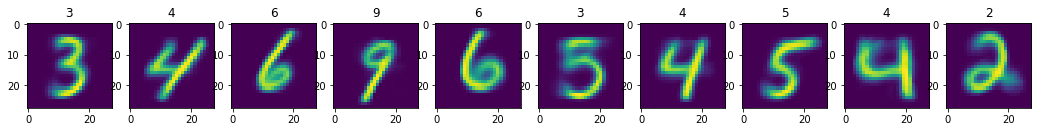

In [0]:
ae.eval()
decode_imgs = ae(imgs.view(imgs.size(0), -1))
decode_imgs = decode_imgs.view(decode_imgs.size(0), 28, 28).detach().cpu()
plt.figure(figsize=(18, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.title(labels[i].item())
    im_show(decode_imgs[i])

In [0]:
torch.save(ae.state_dict(), 'ae.pth')

In [0]:
ae = Autoencoder()
if torch.cuda.device_count() > 1:
    ae = nn.DataParallel(ae)
    
ae = ae.to(device)
ae.load_state_dict(torch.load('ae.pth'))
ae

DataParallel(
  (module): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=1000, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=1000, out_features=1000, bias=True)
      (3): ReLU(inplace)
      (4): Linear(in_features=1000, out_features=2, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=1000, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=1000, out_features=1000, bias=True)
      (3): ReLU(inplace)
      (4): Linear(in_features=1000, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

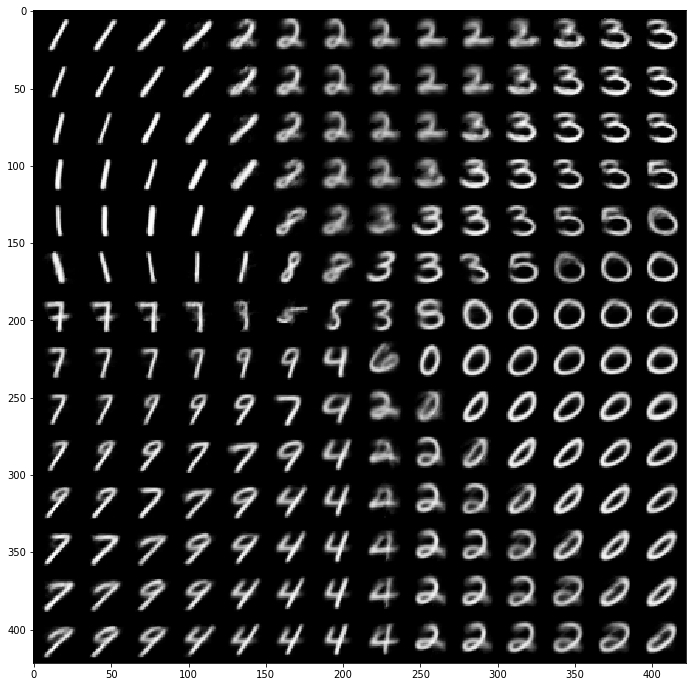

In [0]:
samples = torch.tensor([i for i in itertools.product(np.arange(-10, 10, 1.5), repeat=2)], dtype=torch.float).to(device)
decoded_imgs = ae.module.decoder(samples)
decoded_imgs = decoded_imgs.view(decoded_imgs.size(0),1 , 28, 28).detach().cpu()
grid = make_grid(decoded_imgs, 14)
plt.figure(figsize=(12,12))
plt.imshow(np.transpose( grid, (1, 2, 0)));